In [1]:
import numpy as np
from ase import Atoms
from ase.io import write
import subprocess

# Create a UCl3 molecule using ASE
symbols = ["U", "Cl", "Cl", "Cl"]
positions = np.array([
    [0.000, 0.000, 0.000],     # U
    [0.000, 0.000, 2.5],       # Cl
    [2.2, 0.0, -1.25],         # Cl
    [-2.2, 0.0, -1.25]         # Cl
])
ucl3 = Atoms(symbols=symbols, positions=positions)

# Save to file as xyz
write("ucl3.xyz", ucl3)

# Write Packmol input file
n_molecules = 16

# Get the box size from known density at simulation temperature 1250K
rho = lambda T: 6.72 - 1.52*1E-3 * T  # Density in g/cm^3

density = rho(1250)  # Density at 1250K
U_mass = 238.03 # mass in amu
Cl_mass = 35.453 # mass in amu
ucl3_mass_amu = U_mass + 3 * Cl_mass

amu_to_grams = 1.66053906660e-24  # g
angstroms_per_cm = 1e8  # 1 cm = 10^8 Å

total_mass = n_molecules * ucl3_mass_amu * amu_to_grams  # grams

# Volume in cm^3 from density
volume_cm3 = total_mass / density

# Convert to Å^3
volume_ang3 = volume_cm3 * (angstroms_per_cm)**3

# Box size is the cube root of volume
box_size = volume_ang3 ** (1/3)
with open("packmol.inp", "w") as f:
    f.write(f"""tolerance 2.0
filetype xyz
output ucl3_random.xyz

structure ucl3.xyz
  number {n_molecules}
  inside box 0. 0. 0. {box_size} {box_size} {box_size}
end structure
""")

# Run packmol
result = subprocess.run("packmol < packmol.inp", shell=True)
print(result.stdout)
if result.returncode != 0:
    print("Packmol failed:")
    print(result.stderr)



################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                             Version 21.0.1 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Types of coordinate files specified: xyz
  Seed for random number generator:      1234567
  Output file: ucl3_random.xyz
  Reading coordinate file: ucl3.xyz
  Number of independent structures:            1
  The structures are: 
  Structure            1 :Properties=species:S:1:pos:R:3 pbc="F F F"(           4  atoms)
  Maximum number of GENCAN loops for all molecule packing:          200
  Distance tolerance:    2.0000000000000000     
  Number of molecules of type          

In [2]:
def xyz_to_cp2k_coord(xyz_file, coord_file="coord.inp", box_size=None):
    # 1) Read and skip the header
    with open(xyz_file, 'r') as f:
        lines = f.readlines()
    atom_lines = lines[2:]   # drop the "NNN" and comment lines

    # 2) Write in CP2K format
    with open(coord_file, 'w') as f:
        f.write("&COORD\n")
        for line in atom_lines:
            parts = line.strip().split()
            if len(parts) < 4:
                continue
            elem, xs, ys, zs = parts[:4]
            x, y, z = float(xs), float(ys), float(zs)
            if box_size is not None:
                x %= box_size
                y %= box_size
                z %= box_size
            # two‑space indent, element in width=2, coords width=10 with 6 decimals
            f.write(f"  {elem:<2} {x:10.6f} {y:10.6f} {z:10.6f}\n")
        f.write("&END COORD\n")

# Run this
xyz_to_cp2k_coord("ucl3_random.xyz", box_size=box_size)

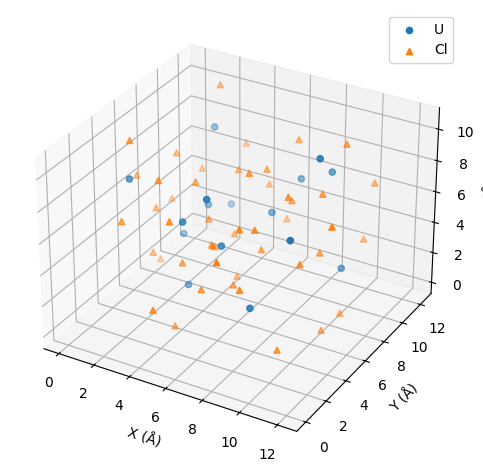

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Load the CP2K coordinates ---
elements = []
coords = []
with open('coord.inp','r') as f:
    inside = False
    for line in f:
        line = line.strip()
        if line.startswith('&COORD'):
            inside = True
            continue
        if line.startswith('&END COORD'):
            break
        if inside:
            tokens = line.split()
            elem = tokens[0]
            x, y, z = map(float, tokens[1:4])
            elements.append(elem)
            coords.append([x,y,z])
coords = np.array(coords)
elements = np.array(elements)

# --- Separate Uranium and Chlorine ---
mask_U  = elements == 'U'
mask_Cl = elements == 'Cl'
pts_U  = coords[mask_U]
pts_Cl = coords[mask_Cl]

# --- Plot in 3D ---
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')

# Uranium atoms as circles
ax.scatter(pts_U[:,0], pts_U[:,1], pts_U[:,2],
           marker='o', label='U')

# Chlorine atoms as triangles
ax.scatter(pts_Cl[:,0], pts_Cl[:,1], pts_Cl[:,2],
           marker='^', label='Cl')

ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
ax.legend()
plt.tight_layout()
plt.savefig('atom_placement.png', dpi=300)


In [4]:
box_size

12.381989681226788